<a href="https://colab.research.google.com/github/HongEnJung/ML-DL/blob/main/kaggle/Walmart_M5%20Forecasting/Walmart_(M5)_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Walmart (M5) 데이터 예측

id: 각 행의 고유한 식별자입니다.

item_id: 제품의 고유한 식별자입니다.

dept_id: 제품이 속한 부서(department)의 식별자입니다.

cat_id: 제품이 속한 카테고리(category)의 식별자입니다.

store_id: 제품이 판매되는 매장의 식별자입니다.

state_id: 매장이 위치한 주(state)의 식별자입니다.

d_1, d_2, ..., d_1913: 매일매일 기록된 제품의 판매량을 나타내는 시계열 데이터입니다. "d_1"은 가장 이른 날짜의 판매량을 의미하고, "d_1913"은 최근 날짜의 판매량을 의미합니다.

변수명이 "_validation"으로 끝나는 컬럼: 대회에서 제공된 데이터셋에 대한 validation 데이터의 판매량을 나타냅니다. 예를 들어, "d_1914"부터 "d_1941"까지의 컬럼은 validation 데이터의 판매량을 의미합니다.

변수명이 "_evaluation"으로 끝나는 컬럼: 예측 대상인 test 데이터셋의 판매량을 나타냅니다. 예를 들어, "d_1942"부터 "d_1969"까지의 컬럼은 test 데이터의 판매량을 의미합니다.

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

pd.set_option('display.max_columns', 50)
plt.style.use('bmh') # 시각화를 더 세련되게 보임
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])



```
calendar.csv: 제품이 판매되는 날짜에 대한 정보를 포함하는 파일입니다. 날짜와 관련된 다양한 특성(예: 요일, 휴일 여부 등)이 기록되어 있습니다.

sales_train_validation.csv: 제품과 매장 별로 기록된 과거의 일일 판매량 데이터가 포함된 파일입니다. "d_1"부터 "d_1913"까지의 컬럼은 해당 날짜의 판매량을 나타냅니다.

sample_submission.csv: 대회에 제출해야 하는 예측 결과의 올바른 형식을 제시한 파일입니다. 평가 부문(Evaluation tab)에서 자세한 정보를 확인할 수 있습니다.

sell_prices.csv: 제품이 각 매장과 날짜에 판매된 가격에 대한 정보가 포함된 파일입니다. 각 제품과 매장에 대한 가격 정보가 기록되어 있습니다.

sales_train_evaluation.csv: 경진 대회 마감일의 한 달 전에 제공되는 파일로, "d_1"부터 "d_1941"까지의 판매 데이터를 포함합니다. 경진 대회에서 제출할 예측 결과와 평가를 수행하는 데 사용됩니다.
```



In [66]:
# 데이터 로드

# cal 제품이 판매되는 날짜에 대한 정보
cal = pd.read_csv('/content/drive/MyDrive/캐글/m5-forecasting-accuracy/calendar.csv')
# 과거의 일일 판매량 데이터
stv = pd.read_csv('/content/drive/MyDrive/캐글/m5-forecasting-accuracy/sales_train_validation.csv')
# ss 평가 부분
ss = pd.read_csv('/content/drive/MyDrive/캐글/m5-forecasting-accuracy/sample_submission.csv')
# sellp 제품이 각 매장과 날짜에 판매된 가격에 대한 정보
sellp = pd.read_csv('/content/drive/MyDrive/캐글/m5-forecasting-accuracy/sell_prices.csv')

In [101]:
sellp

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00
6841117,WI_3,FOODS_3_827,11618,1.00
6841118,WI_3,FOODS_3_827,11619,1.00
6841119,WI_3,FOODS_3_827,11620,1.00


In [67]:
ss.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [68]:
stv[8412:]

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,...,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
8412,FOODS_3_090_CA_3_validation,FOODS_3_090,FOODS_3,FOODS,CA_3,CA,108,132,102,120,106,123,279,175,186,120,0,0,0,0,0,0,0,0,0,...,130,156,133,114,80,75,113,81,107,160,124,107,84,88,90,129,160,204,86,100,88,77,141,139,130
8413,FOODS_3_091_CA_3_validation,FOODS_3_091,FOODS_3,FOODS,CA_3,CA,2,4,2,2,4,4,2,4,1,2,3,1,4,5,2,1,1,1,5,...,2,2,0,2,4,1,0,0,1,3,0,3,0,1,1,1,0,2,0,0,2,0,3,2,4
8414,FOODS_3_092_CA_3_validation,FOODS_3_092,FOODS_3,FOODS,CA_3,CA,0,1,2,2,0,0,5,2,2,2,0,2,0,0,0,0,0,0,0,...,2,1,2,1,2,3,0,0,3,1,1,2,1,0,0,7,3,2,0,1,1,0,0,4,1
8415,FOODS_3_093_CA_3_validation,FOODS_3_093,FOODS_3,FOODS,CA_3,CA,3,7,5,16,5,5,5,17,7,7,12,6,11,7,0,9,3,6,7,...,1,6,2,4,4,4,2,3,2,3,5,4,4,4,3,1,3,4,1,3,4,4,2,1,4
8416,FOODS_3_094_CA_3_validation,FOODS_3_094,FOODS_3,FOODS,CA_3,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,3,0,2,0,1,1,3,3,1,0,2,3,0,1,1,1,0,1,1,0,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,0,3,1,4,1,0,0,3,4,4,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,2,0,0,0,0,0,1,0,0,1
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,0,5,0,1,1,3,1,1,0,4,2,0,1,2,1,...,0,0,1,1,2,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,2,4,1,8,5,2,7,5,3,5,20,8,10,3,3,...,0,0,1,1,2,1,4,0,0,2,2,4,0,0,0,2,1,0,2,0,1,0,0,1,0
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,2,1,1,1,1,2,0,1,0,3,0,0,1,0,0,1,0,3,1,3


#### Visualizing the data for a single item

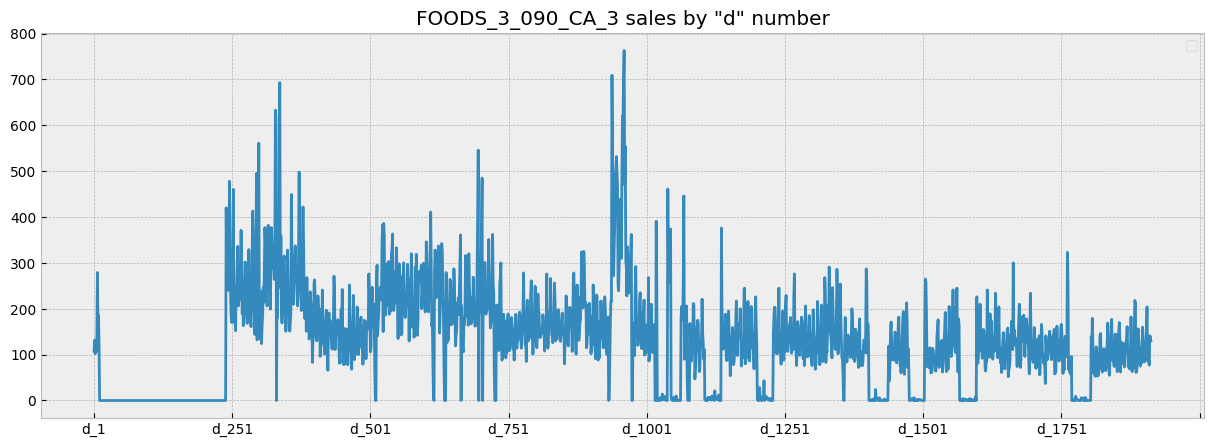

In [69]:
d_cols = [c for c in stv.columns if 'd_' in c] # sales data columns

# Below we are chaining the following steps in pandas:
# 1. Select the item
# 2. Set the id as the index, Keep only sales data columns
# 3. Transform so it's a columns
# 4. Plot the data
stv.loc[stv['id']=='FOODS_3_090_CA_3_validation'].set_index('id')[d_cols].T.plot(figsize = (15,5), title='FOODS_3_090_CA_3 sales by "d" number',
                                                                               color=next(color_cycle))
plt.legend('')
plt.show()

Merging the data with real datas

In [70]:
# calendar data looks like this(only showing columns we care about for now)
cal[['d','date','event_name_1','event_name_2','event_type_1','event_type_2','snap_CA']].head()

,d,date,event_name_1,event_name_2,event_type_1,event_type_2,snap_CA
0,d_1,2011-01-29,NaN,NaN,NaN,NaN,0
1,d_2,2011-01-30,NaN,NaN,NaN,NaN,0
2,d_3,2011-01-31,NaN,NaN,NaN,NaN,0
3,d_4,2011-02-01,NaN,NaN,NaN,NaN,1
4,d_5,2011-02-02,NaN,NaN,NaN,NaN,1


In [71]:
stv.loc[stv['id']=='FOODS_3_090_CA_3_validation']

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,...,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
8412,FOODS_3_090_CA_3_validation,FOODS_3_090,FOODS_3,FOODS,CA_3,CA,108,132,102,120,106,123,279,175,186,120,0,0,0,0,0,0,0,0,0,...,130,156,133,114,80,75,113,81,107,160,124,107,84,88,90,129,160,204,86,100,88,77,141,139,130


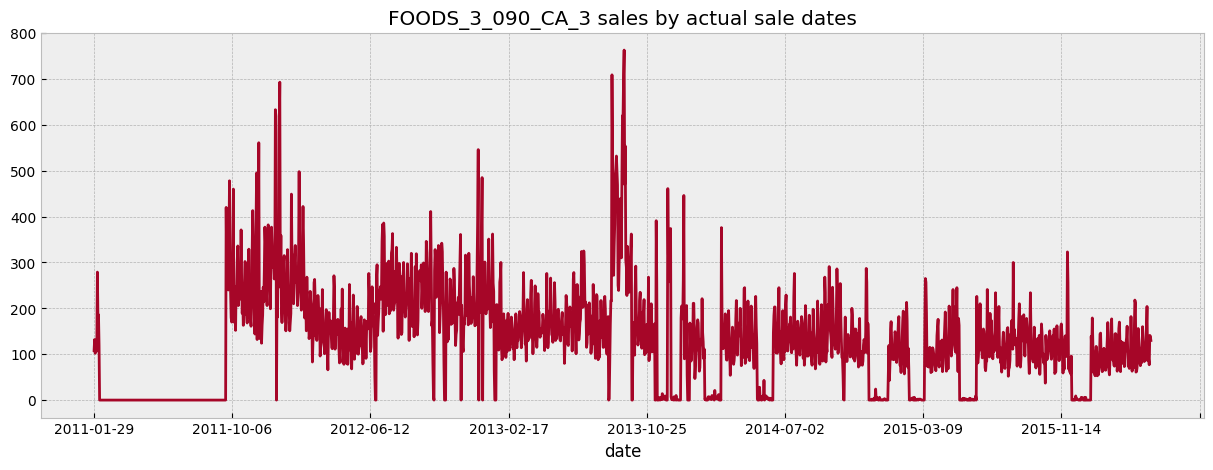

In [72]:
# Marge calendar on our items' data
example = stv.loc[stv['id'] == 'FOODS_3_090_CA_3_validation'][d_cols].T
example = example.rename(columns={8412: 'FOODS_3_090_CA_3'}) # Name it correctly
example = example.reset_index().rename(columns={'index':'d'}) # make the index "d"
example = example.merge(cal, how='left', validate = '1:1')
example.set_index('date')['FOODS_3_090_CA_3'].plot(figsize=(15,5),color=next(color_cycle), title='FOODS_3_090_CA_3 sales by actual sale dates')
plt.show()

In [73]:
example

,d,FOODS_3_090_CA_3,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,d_1,108,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,d_2,132,2011-01-30,11101,Sunday,2,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,d_3,102,2011-01-31,11101,Monday,3,1,2011,NaN,NaN,NaN,NaN,0,0,0
3,d_4,120,2011-02-01,11101,Tuesday,4,2,2011,NaN,NaN,NaN,NaN,1,1,0
4,d_5,106,2011-02-02,11101,Wednesday,5,2,2011,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,d_1909,88,2016-04-20,11612,Wednesday,5,4,2016,NaN,NaN,NaN,NaN,0,0,0
1909,d_1910,77,2016-04-21,11612,Thursday,6,4,2016,NaN,NaN,NaN,NaN,0,0,0
1910,d_1911,141,2016-04-22,11612,Friday,7,4,2016,NaN,NaN,NaN,NaN,0,0,0
1911,d_1912,139,2016-04-23,11613,Saturday,1,4,2016,NaN,NaN,NaN,NaN,0,0,0


In [74]:
stv.loc[stv['id']=='HOUSEHOLD_1_118_CA_3_validation']

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,...,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
6776,HOUSEHOLD_1_118_CA_3_validation,HOUSEHOLD_1_118,HOUSEHOLD_1,HOUSEHOLD,CA_3,CA,17,27,28,32,24,23,25,12,23,36,15,24,13,22,27,39,12,37,9,...,17,19,27,30,35,25,21,41,8,24,24,16,20,9,11,21,20,38,13,22,19,52,14,25,31


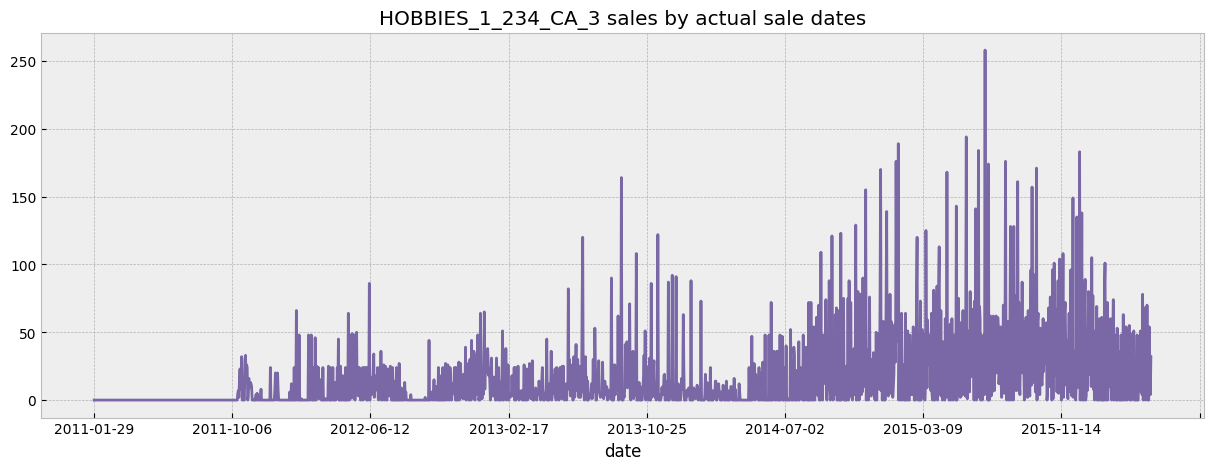

In [75]:
# Marge calendar on our items' data
example2 = stv.loc[stv['id'] == 'HOBBIES_1_234_CA_3_validation'][d_cols].T
example2 = example2.rename(columns={6324: 'HOBBIES_1_234_CA_3'}) # Name it correctly
example2 = example2.reset_index().rename(columns={'index':'d'}) # make the index "d"
example2 = example2.merge(cal, how='left', validate = '1:1')
example2.set_index('date')['HOBBIES_1_234_CA_3'].plot(figsize=(15,5),color=next(color_cycle), title='HOBBIES_1_234_CA_3 sales by actual sale dates')
plt.show()

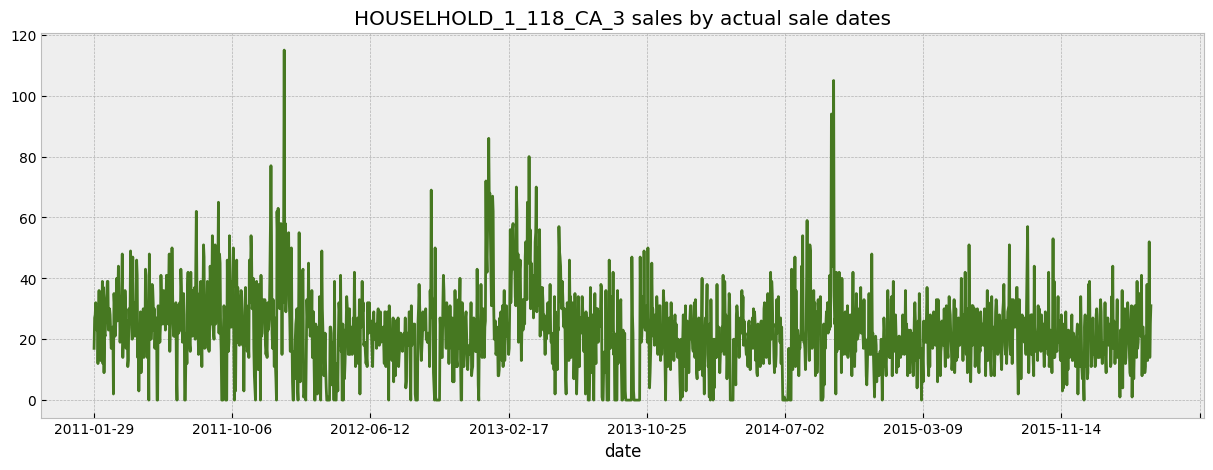

In [76]:
# Marge calendar on our items' data
example3 = stv.loc[stv['id'] == 'HOUSEHOLD_1_118_CA_3_validation'][d_cols].T
example3 = example3.rename(columns={6776: 'HOUSELHOLD_1_118_CA_3'}) # Name it correctly
example3 = example3.reset_index().rename(columns={'index':'d'}) # make the index "d"
example3 = example3.merge(cal, how='left', validate = '1:1')
example3.set_index('date')['HOUSELHOLD_1_118_CA_3'].plot(figsize=(15,5),color=next(color_cycle), title='HOUSELHOLD_1_118_CA_3 sales by actual sale dates')
plt.show()

Sales broken down by time. variables

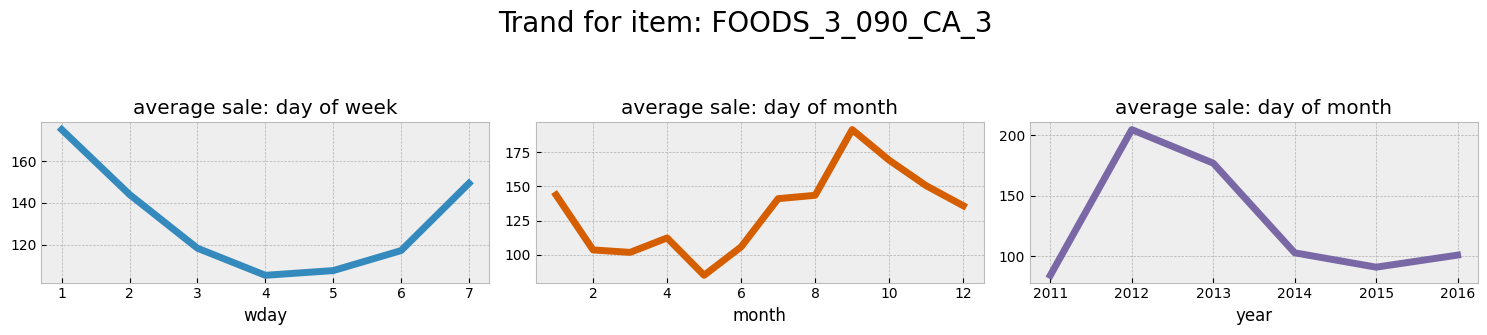

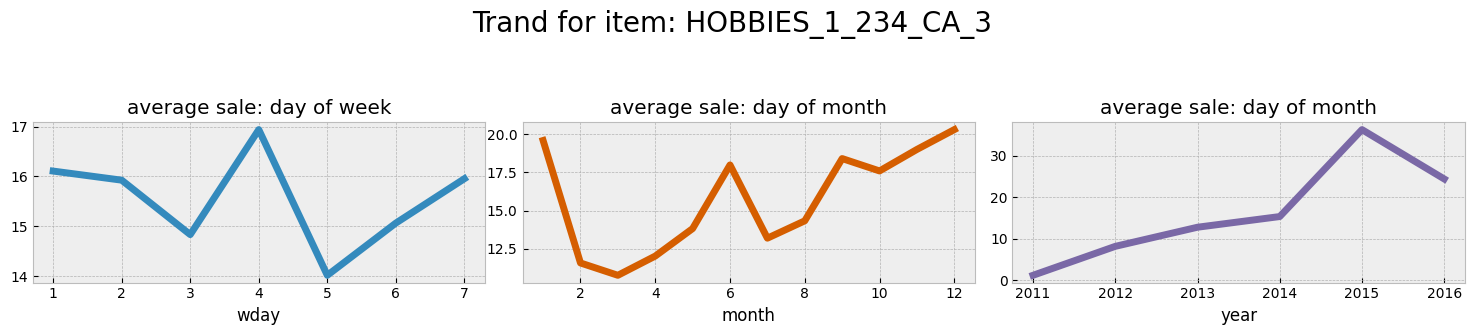

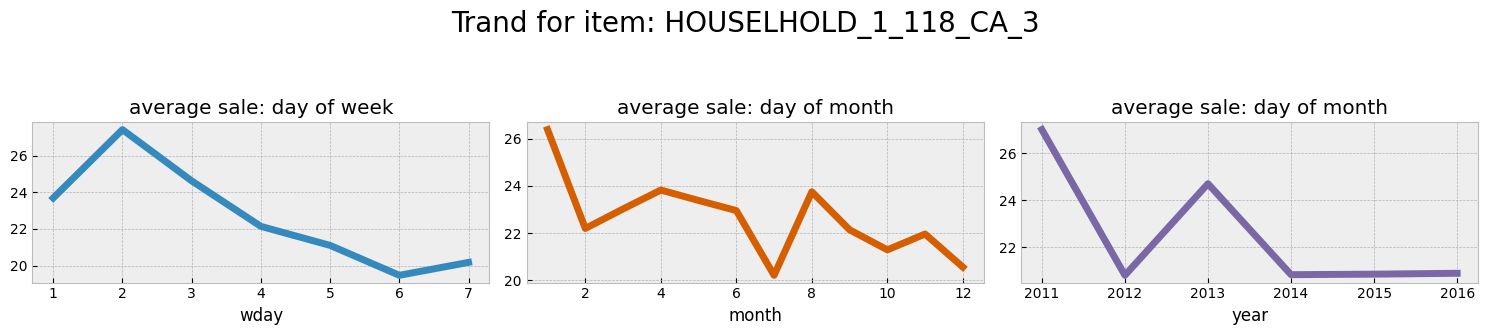

In [81]:
import warnings
warnings.filterwarnings("ignore")

examples = ['FOODS_3_090_CA_3','HOBBIES_1_234_CA_3', 'HOUSELHOLD_1_118_CA_3']

example_df = [example, example2, example3]
for i in [0,1,2]:
  fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,3))
  example_df[i].groupby('wday').mean()[examples[i]].plot(kind='line', title='average sale: day of week', lw=5, color=color_pal[0], ax=ax1)

  example_df[i].groupby('month').mean()[examples[i]].plot(kind='line', title='average sale: day of month', lw=5, color=color_pal[4], ax=ax2)

  example_df[i].groupby('year').mean()[examples[i]].plot(kind='line', title='average sale: day of month', lw=5, color=color_pal[2], ax=ax3)

  fig.suptitle(f'Trand for item: {examples[i]}',
               size=20, y=1.1)
  plt.tight_layout()
  plt.show()

Lets look at a lot of different items

1. 일부 상품은 일정 기간 동안 판매되지 않는 경우가 있습니다. 이는 상품의 재고 소진이나 재고 보충 등과 관련될 수 있습니다.

2. 일부 상품은 하루에 1개 이하의 판매량을 보이는 경우가 있습니다. 이는 매우 예측하기 어려운 상품으로 분류될 수 있습니다. 이러한 경우 판매량 예측이 도전적일 수 있습니다.

3. 다른 상품들은 수요의 급증(슈퍼볼 일요일 등)을 보일 수 있습니다. 이러한 경우에는 "이벤트"와 같은 추가 정보가 판매량 예측에 도움이 될 수 있습니다.

In [83]:
# 20개의 다른 상품 판매량을 나타내는 작업
twenty_examples = stv.sample(20, random_state = 529).set_index('id')[d_cols].T.merge(cal.set_index('d')['date'],
                                                                                     left_index=True,
                                                                                     right_index=True,
                                                                                     validate='1:1').set_index('date')

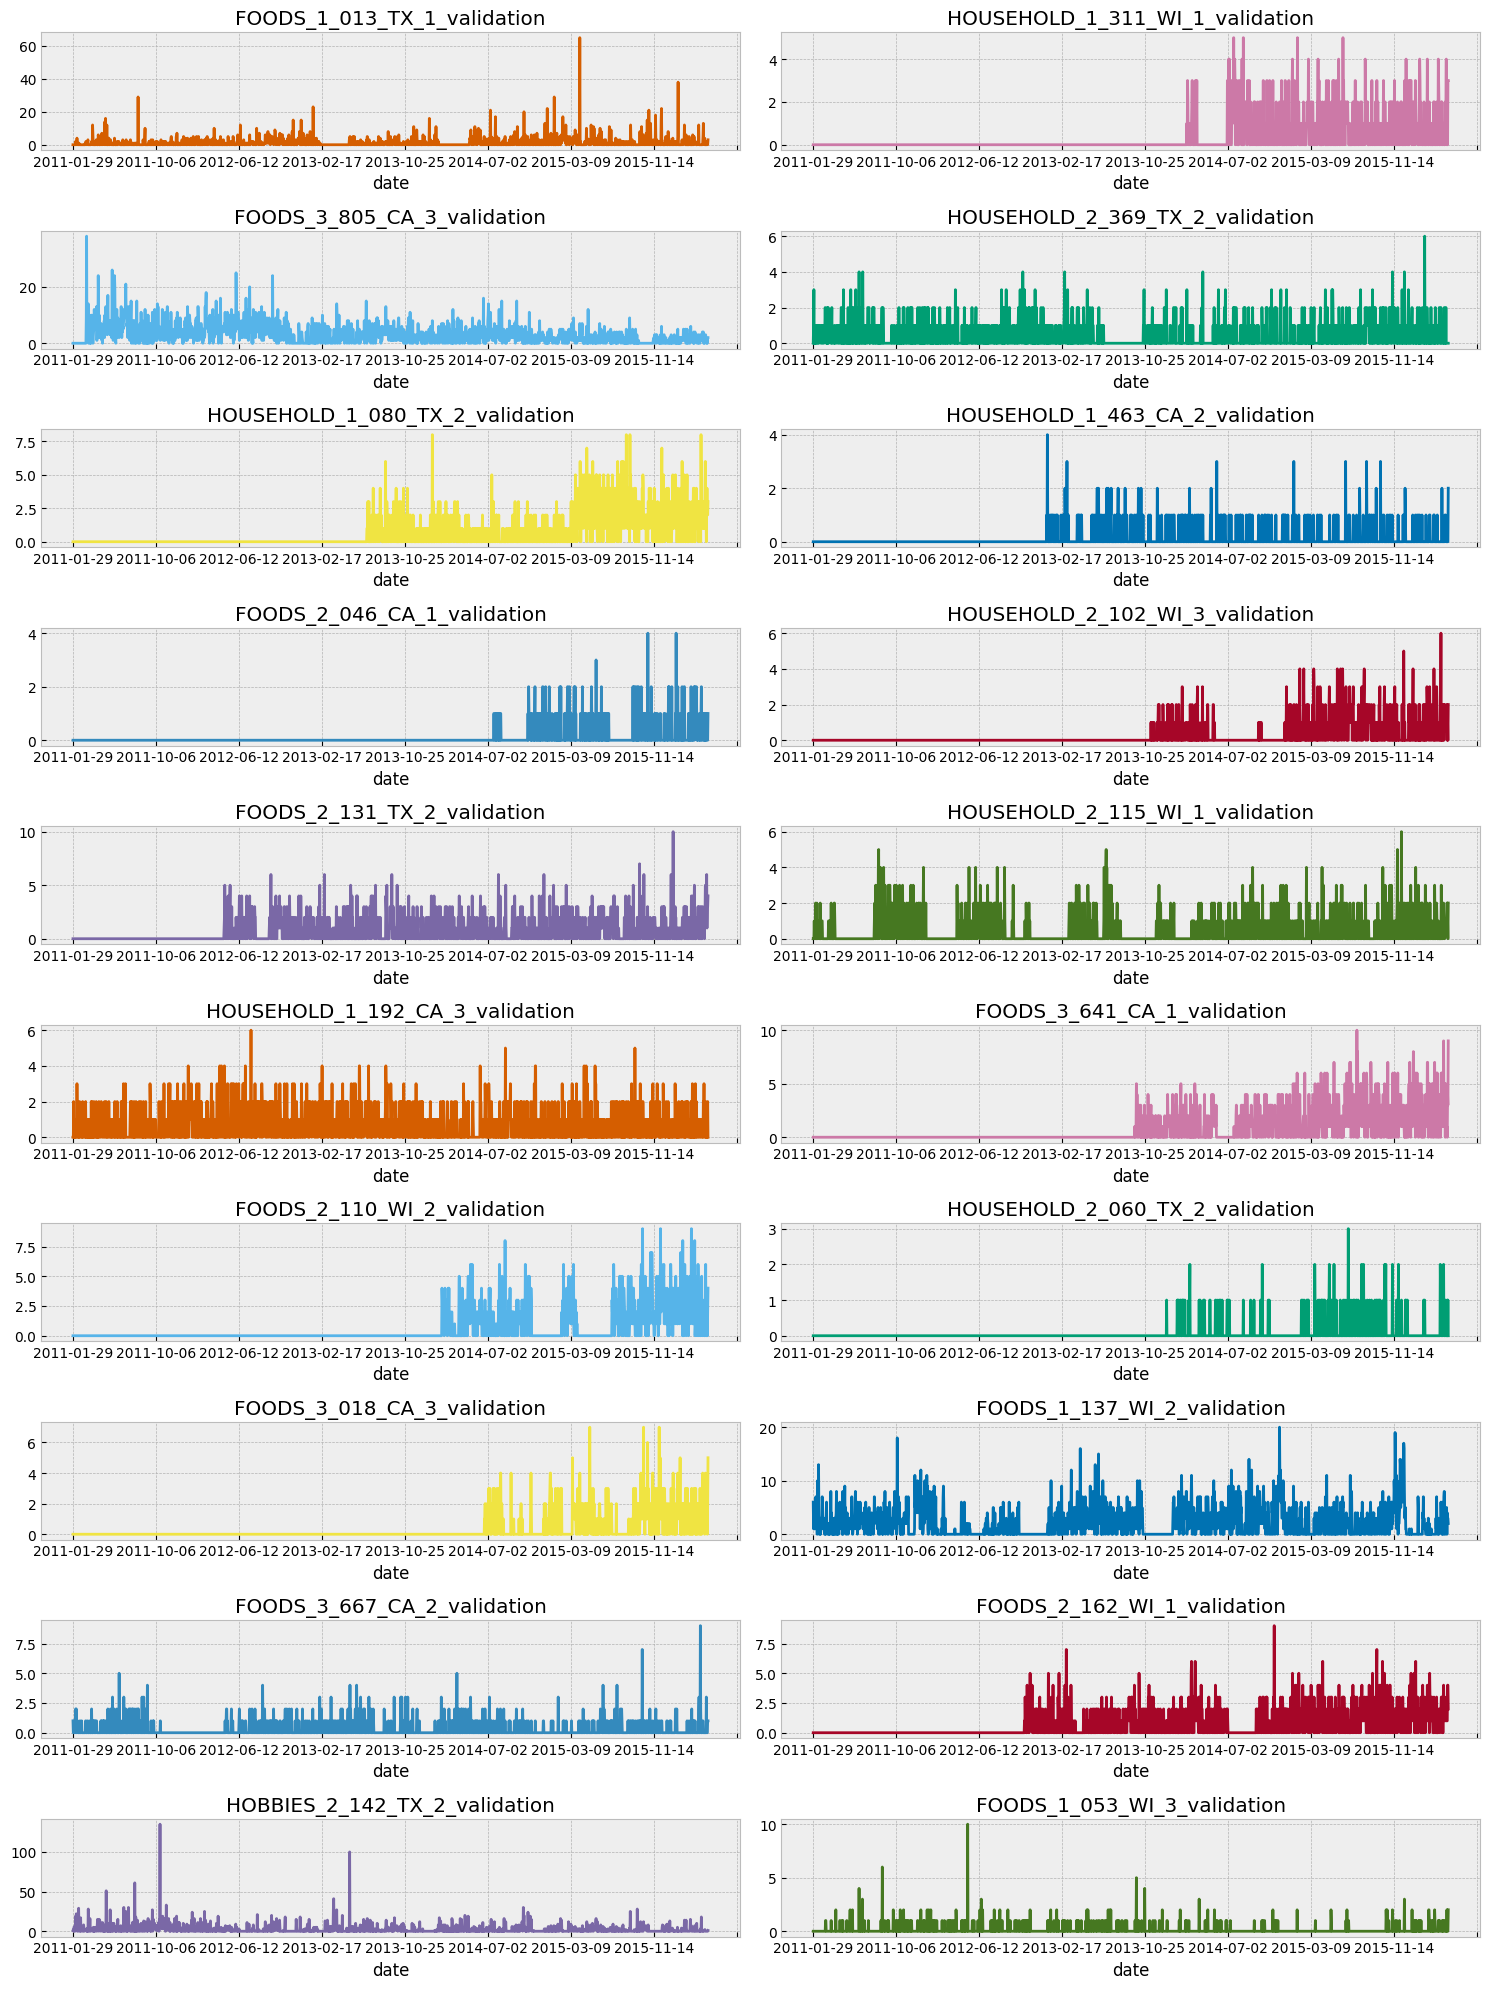

In [84]:
fig, axs = plt.subplots(10, 2, figsize = (15,20))
axs = axs.flatten() # 다차원 배열로 구성된 축(ax)을 1차원으로 펼치는 작업
ax_idx = 0
for item in twenty_examples.columns:
  twenty_examples[item].plot(title=item,
                             color=next(color_cycle),
                             ax=axs[ax_idx])
  ax_idx +=1

plt.tight_layout()
plt.show()

Combined Sales over Time by Type

In [85]:
stv['cat_id'].unique()

array(['HOBBIES', 'HOUSEHOLD', 'FOODS'], dtype=object)

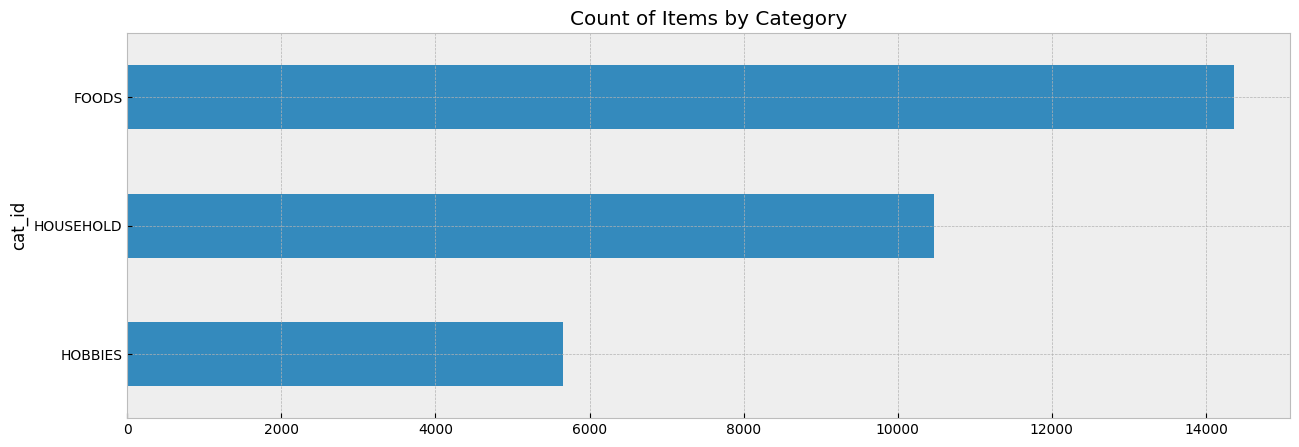

In [86]:
stv.groupby('cat_id').count()['id'].sort_values().plot(kind='barh', figsize=(15,5), title='Count of Items by Category')
plt.show()

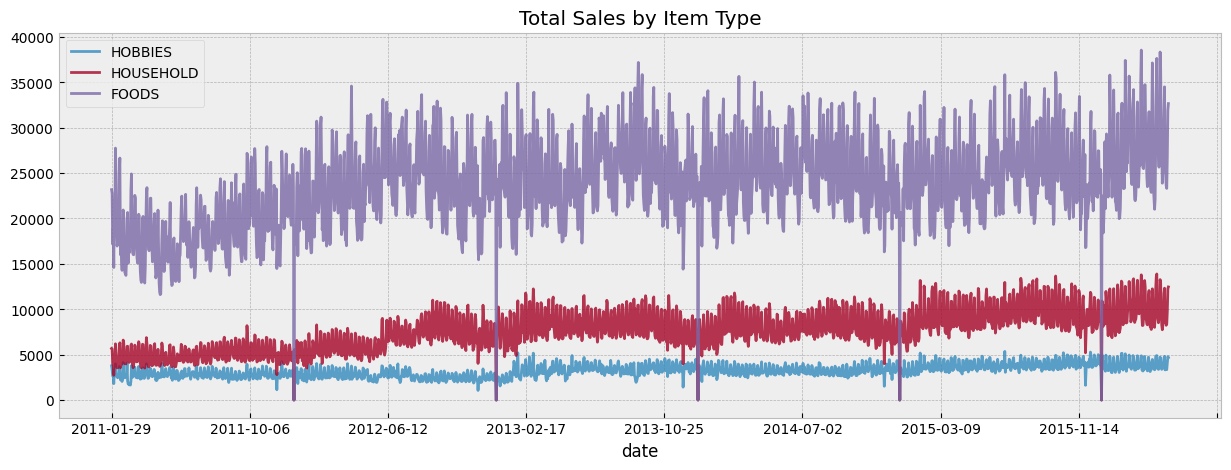

In [87]:
past_sales = stv.set_index('id')[d_cols].T.merge(cal.set_index('d')['date'],
                                                 left_index=True,
                                                 right_index=True,
                                                 validate='1:1').set_index('date')
for i in stv['cat_id'].unique():
  items_col = [c for c in past_sales.columns if i in c]
  past_sales[items_col].sum(axis=1).plot(figsize=(15,5), alpha=0.8, title = 'Total Sales by Item Type')
plt.legend(stv['cat_id'].unique())
plt.show()

Rollout of items being sold

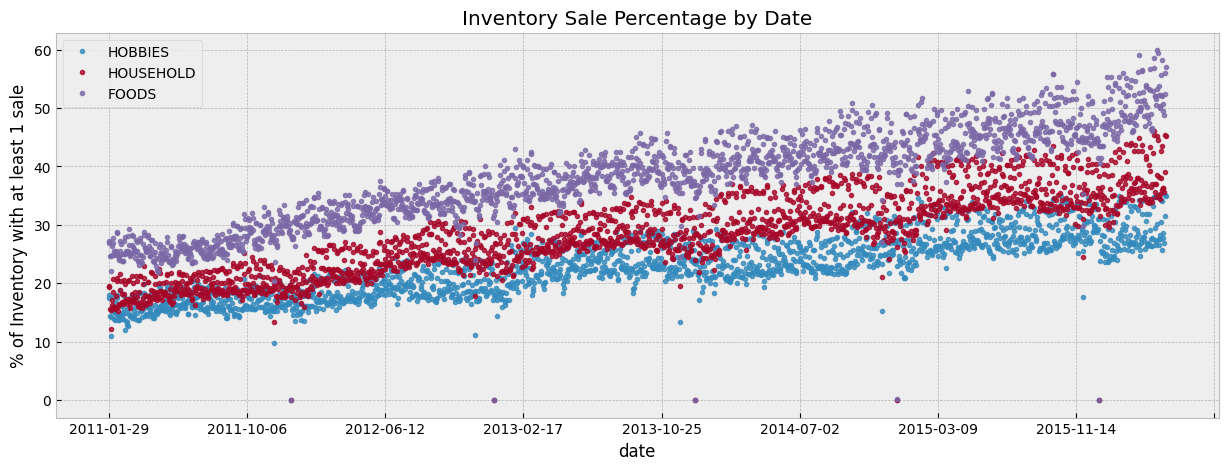

In [90]:
past_sales_clipped = past_sales.clip(0,1)
for i in stv['cat_id'].unique():
  items_col = [c for c in past_sales.columns if i in c]
  (past_sales_clipped[items_col].mean(axis=1)*100).plot(figsize=(15,5),
                                                        alpha=0.8,
                                                        title = 'Inventory Sale Percentage by Date',
                                                        style = '.')
plt.ylabel('% of Inventory with at least 1 sale')
plt.legend(stv['cat_id'].unique())
plt.show()

Sales by Store

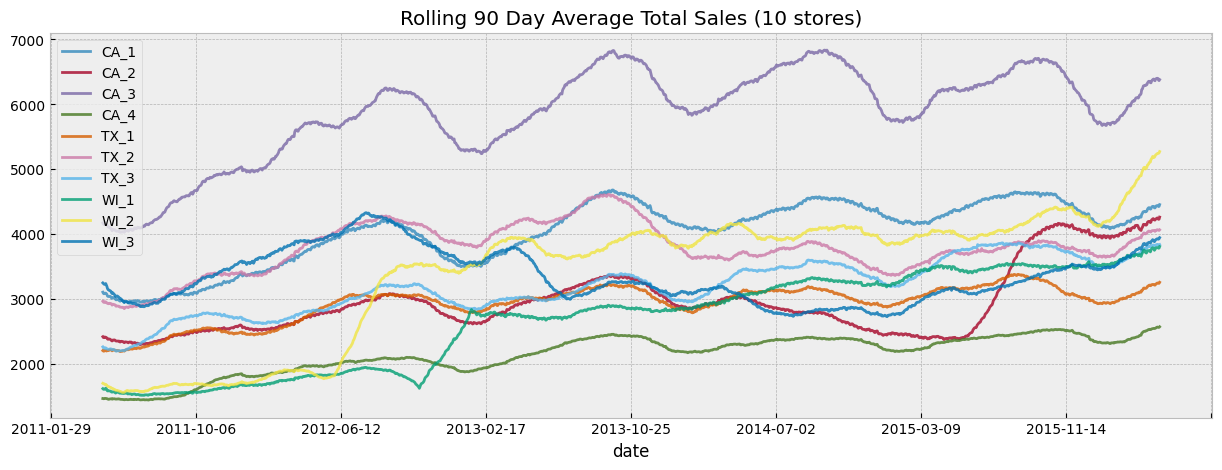

In [98]:
store_list = sellp['store_id'].unique()
for s in store_list:
  store_items = [c for c in past_sales.columns if s in c] # 특정 문자 s가 포함된 열
  # rolling(90).mean() 90일 이동평균
  past_sales[store_items].sum(axis=1).rolling(90).mean().plot(figsize=(15,5),
                                                              alpha=0.8,
                                                              title = 'Rolling 90 Day Average Total Sales (10 stores)')
plt.legend(store_list)
plt.show()

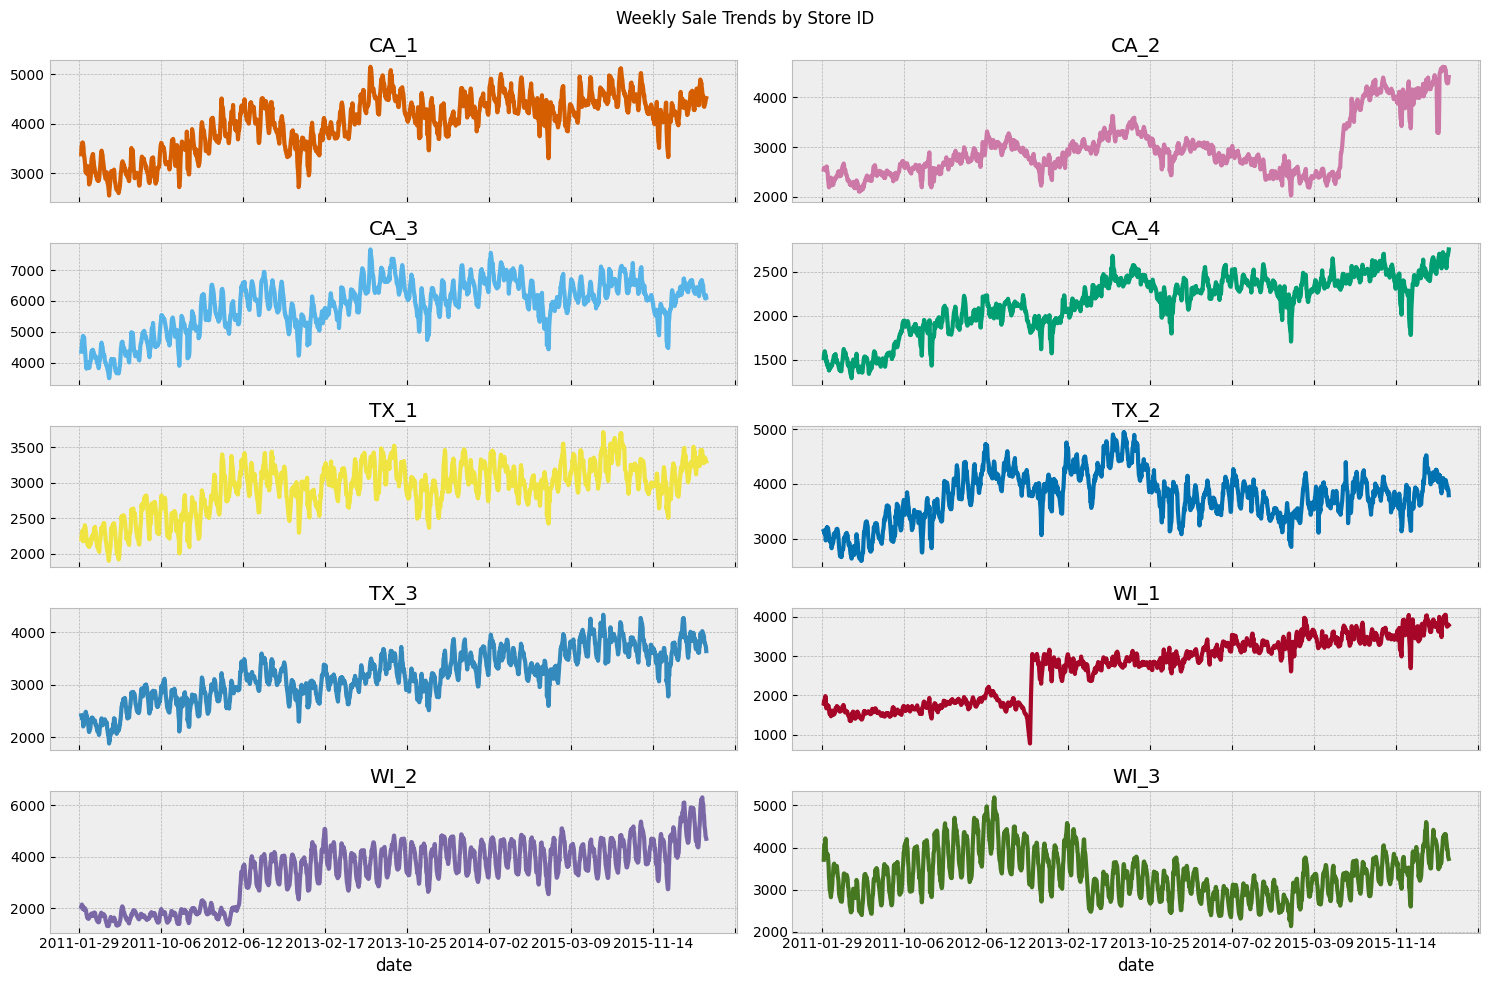

In [100]:
fig, axes = plt.subplots(5,2, figsize = (15,10), sharex =True)
axes = axes.flatten()
ax_idx = 0
for s in store_list:
  store_items = [c for c in past_sales.columns if s in c]
  past_sales[store_items].sum(axis=1).rolling(7).mean().plot(alpha=1,
                                                             ax=axes[ax_idx],
                                                             title=s,
                                                             lw=3,
                                                             color = next(color_cycle))
  ax_idx +=1
plt.suptitle('Weekly Sale Trends by Store ID')
plt.tight_layout()
plt.show()

Sale Prices

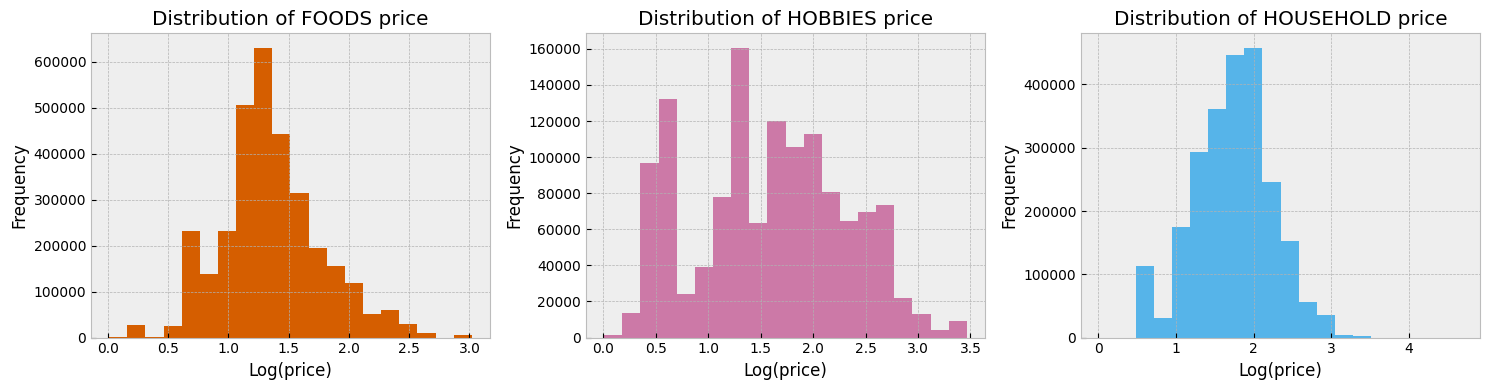

In [104]:
sellp['Category'] = sellp['item_id'].str.split('_', expand=True)[0]
fig, axs = plt.subplots(1,3, figsize=(15,4))
i=0
for cat, d in sellp.groupby('Category'):
  ax = d['sell_price'].apply(np.log1p).plot(kind='hist',
                                            bins=20, title=f'Distribution of {cat} price',
                                            ax=axs[i], color=next(color_cycle))
  ax.set_xlabel('Log(price)')
  i +=1
plt.tight_layout()

A simple submission

In [109]:
# 최근 30일의 평균 판매량
thirty_day_avg_map = stv.set_index('id')[d_cols[-30:]].mean(axis=1).to_dict()
fcols = [f for f in ss.columns if 'F' in f]
for f in fcols:
  ss[f] = ss['id'].map(thirty_day_avg_map).fillna(0)

ss.to_csv('submission.csv', index=False)

In [108]:
ss

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.966667,0.966667,0.966667,0.966667,0.966667,0.966667,0.966667,0.966667,0.966667,0.966667,0.966667,0.966667,0.966667,0.966667,0.966667,0.966667,0.966667,0.966667,0.966667,0.966667,0.966667,0.966667,0.966667,0.966667,0.966667,0.966667,0.966667,0.966667
1,HOBBIES_1_002_CA_1_validation,0.133333,0.133333,0.133333,0.133333,0.133333,0.133333,0.133333,0.133333,0.133333,0.133333,0.133333,0.133333,0.133333,0.133333,0.133333,0.133333,0.133333,0.133333,0.133333,0.133333,0.133333,0.133333,0.133333,0.133333,0.133333,0.133333,0.133333,0.133333
2,HOBBIES_1_003_CA_1_validation,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667
3,HOBBIES_1_004_CA_1_validation,2.100000,2.100000,2.100000,2.100000,2.100000,2.100000,2.100000,2.100000,2.100000,2.100000,2.100000,2.100000,2.100000,2.100000,2.100000,2.100000,2.100000,2.100000,2.100000,2.100000,2.100000,2.100000,2.100000,2.100000,2.100000,2.100000,2.100000,2.100000
4,HOBBIES_1_005_CA_1_validation,1.266667,1.266667,1.266667,1.266667,1.266667,1.266667,1.266667,1.266667,1.266667,1.266667,1.266667,1.266667,1.266667,1.266667,1.266667,1.266667,1.266667,1.266667,1.266667,1.266667,1.266667,1.266667,1.266667,1.266667,1.266667,1.266667,1.266667,1.266667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
60976,FOODS_3_824_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
60977,FOODS_3_825_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
60978,FOODS_3_826_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
